Imports

# Imports

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import re
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout


# Load Dataset

In [41]:
train_df = pd.read_csv("./train.csv",index_col="id")

In [42]:
test_df = pd.read_csv("./test.csv",index_col='id')

# Data pre-processing

In [43]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2.0,NaN,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2.0,NaN,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2.0,NaN,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2.0,NaN,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2.0,NaN,2006.0,rejected,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0


In [44]:
{"train":train_df.shape, "test": test_df.shape}

{'train': (187066, 44), 'test': (97320, 1)}

# Features Selection

In [45]:
train_df = train_df.iloc[:,[0,1,2,3,4,5,6,35,36,37,38,39,40,41,42,43]]
train_df["rating"].replace(["approved", "rejected"], [1,0],inplace=True)
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0


# Target Feature

<ipython-input-46-e072d358cf93>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')


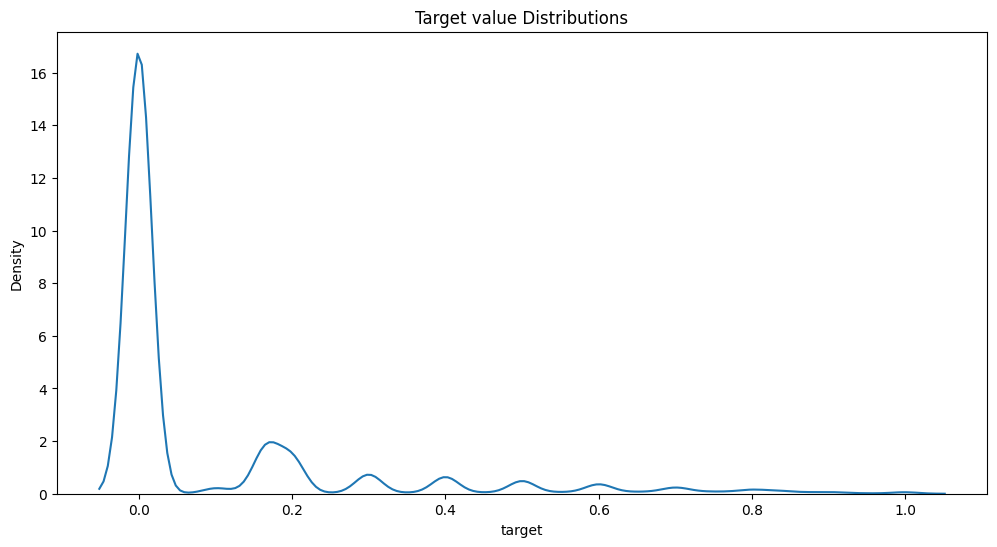

In [46]:

plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

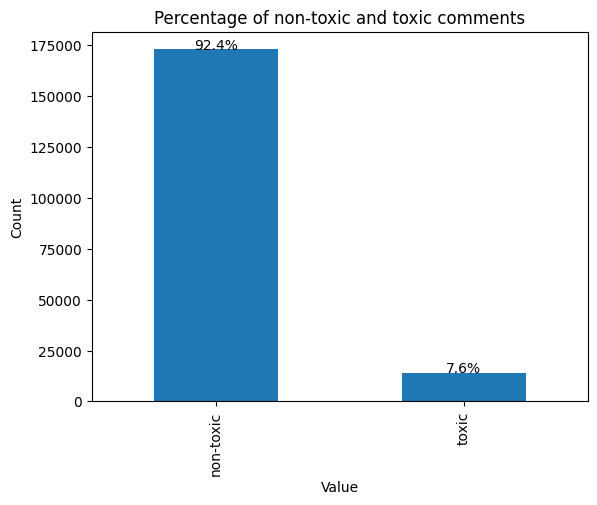

In [68]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")


# count the number of occurrences of each value
value_counts = temp.value_counts()

# calculate the percentage of each value
percentages = value_counts / len(temp) * 100

# plot the bar graph with percentages as annotations
ax = value_counts.plot(kind='bar')
for i, v in enumerate(value_counts):
    ax.text(i, v+0.5, f"{percentages[i]:.1f}%", ha='center')
plt.title('Percentage of non-toxic and toxic comments')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

# Wordclouds

In [71]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

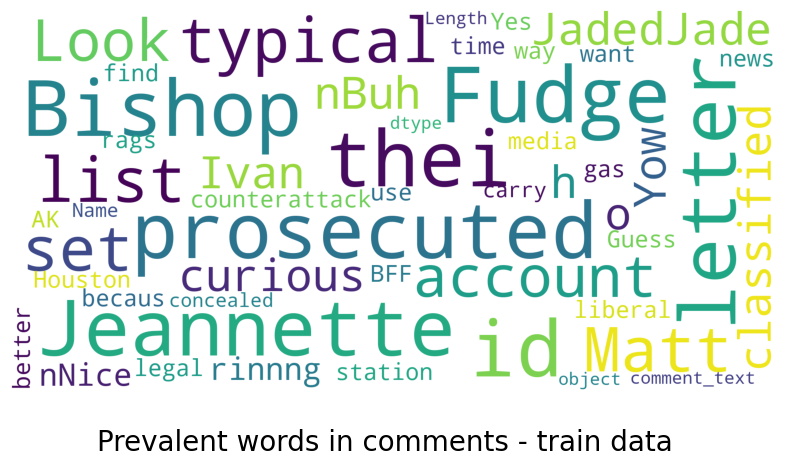

In [79]:
show_wordcloud(train_df['comment_text'].sample(2000), title = 'Prevalent words in comments - train data')

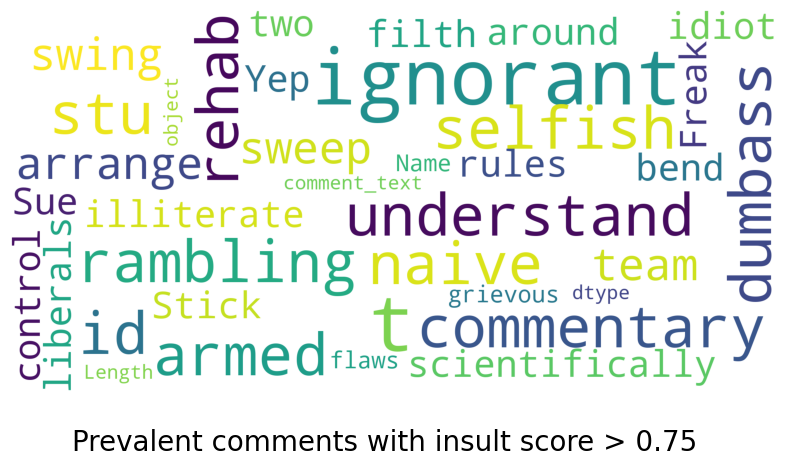

In [78]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(2000), title = 'Prevalent comments with insult score > 0.75')

# Preprocessing Text and Train-Test Split:

In [83]:
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: user 1min 24s, sys: 196 ms, total: 1min 25s
Wall time: 1min 28s


In [85]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0,haha guy bunch loser


In [86]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 41.7 s, sys: 113 ms, total: 41.8 s
Wall time: 42.6 s


In [100]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_val, y_train, y_val = train_test_split(feature, output)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(140299, 1)
(46767, 1)
(140299, 1)
(46767, 1)


In [110]:
train = pd.concat([X_train, y_train,], axis=1, join="inner")
train

,preprocessed_text,target
id,,
288189,thousand research,0.000000
293608,economist thing equit countri progress incom t...,0.000000
419549,yoga one grain truth unsubstanti nonsens post ...,0.500000
433613,nice uies fatialofa moevao palauni osburn paga...,0.000000
239715,effect slow us order reflect upon engag other ...,0.000000
...,...,...
467592,captain boss anarchi high sea,0.000000
276013,common youth sport coach guy got probabl got n...,0.000000
380535,alreadi lost permit convict count unlaw use we...,0.000000


In [101]:
val = pd.concat([X_val, y_val], axis=1, join="inner")
val


,preprocessed_text,target
id,,
253752,wonder mani employe opt reloc compani headquar...,0.000000
319241,buy 30 look 48 state wait silver hit 80 weeeee...,0.000000
251048,colleg fifti year ago time student athlet athl...,0.000000
250681,even half strength bundi famili reunion 100 peopl,0.000000
249111,callahan one three co wrote oppos argument bal...,0.000000
...,...,...
348068,wanton kill 50 plus homosexu bar would warrant...,0.544118
382483,post day man think like 63 year road built mon...,0.000000
269476,get outta rhyner someon lose unfortun wind one...,0.400000


In [131]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


# Saving 

In [132]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_val.to_pickle('X_val.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_val.to_pickle('y_val.pkl')

In [134]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_val = pd.read_pickle('X_val.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_val = pd.read_pickle('y_val.pkl')

#Bag Of Words

In [143]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_val['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(140299, 30000)
(46767, 30000)
(97320, 30000)


# SGD Regessor

In [144]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02246349654860043
Mean Squared Error on cv set:  0.023329477409800514
**************************************************
1e-05 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.021715634613094094
Mean Squared Error on cv set:  0.02330229349254917
**************************************************
0.0001 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02410667080734474
Mean Squared Error on cv set:  0.024376862583017318
**************************************************
0.0001 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02178224320157736
Mean Squared Error on cv set:  0.023353298605505415
**************************************************
0.001 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.030594148921589882
Mean Squared Error on cv set:  0.03055346406821401
**************************************************
0.001 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.022288873271352625
Mean Squared Error on cv set:  0.023659773756499705
**************************************************
0.01 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03756645973168527
Mean Squared Error on cv set:  0.03754692480621987
**************************************************
0.01 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.026505132995223286
Mean Squared Error on cv set:  0.027085018476616207
**************************************************
0.1 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03756556703399896
Mean Squared Error on cv set:  0.0375461184634605
**************************************************
0.1 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.033543078396742664
Mean Squared Error on cv set:  0.03362051862965847
**************************************************
1 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.037565796585012724
Mean Squared Error on cv set:  0.03754632427648783
**************************************************
1 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03673540458819466
Mean Squared Error on cv set:  0.03671245427204486
**************************************************
10 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03756583415446004
Mean Squared Error on cv set:  0.03754635807517958
**************************************************
10 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.0374753729148406
Mean Squared Error on cv set:  0.03745571920122217
**************************************************
100 l1 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.037565847867250514
Mean Squared Error on cv set:  0.03754637041917522
**************************************************
100 l2 :


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03756073687720602
Mean Squared Error on cv set:  0.037541406217073914
**************************************************


In [149]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# Result

In [151]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.430279
stupid,0.326381
crap,0.257399
moron,0.227737
pathet,0.227183
damn,0.224645
dumb,0.205418
hypocrit,0.203672
ass,0.190221
liar,0.185011
